In [1]:
library(tidyverse)
library(janitor)
library(corrplot)
library(caret)
library(lubridate)
library(e1071)
library(leaflet)
library(randomForest)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.5
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘janitor’

The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test

corrplot 0.85 loaded
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift


Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2

In [32]:
#devtools::install_github('cran/Metrics')

✔  checking for file ‘/private/var/folders/vg/6bswdsv92tz16s_1c281j3km0000gn/T/RtmpP94ddv/remotes1392215d5d1a/cran-Metrics-57e29e9/DESCRIPTION’ (986ms)
─  preparing ‘Metrics’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘Metrics_0.1.4.tar.gz’
   


In [2]:
library(Metrics)


Attaching package: ‘Metrics’

The following objects are masked from ‘package:caret’:

    precision, recall



In [3]:
input_data <- 'Sendy/Train.csv'
input_data <- read.csv(input_data, header=T) %>% clean_names()
head(input_data)

,order_no,user_id,vehicle_type,platform_type,personal_or_business,placement_day_of_month,placement_weekday_mo_1,placement_time,confirmation_day_of_month,confirmation_weekday_mo_1,⋯,arrival_at_destination_time,distance_km,temperature,precipitation_in_millimeters,pickup_lat,pickup_long,destination_lat,destination_long,rider_id,time_from_pickup_to_arrival
,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<fct>,<int>,<int>,⋯,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,⋯,10:39:55 AM,4,20.4,NA,-1.317755,36.83037,-1.300406,36.82974,Rider_Id_432,745
2,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,⋯,12:17:22 PM,16,26.4,NA,-1.351453,36.89932,-1.295004,36.81436,Rider_Id_856,1993
3,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,⋯,1:00:38 PM,3,NA,NA,-1.308284,36.84342,-1.300921,36.82820,Rider_Id_155,455
4,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,⋯,10:05:27 AM,9,19.2,NA,-1.281301,36.83240,-1.257147,36.79506,Rider_Id_855,1341
5,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,⋯,10:25:37 AM,9,15.4,NA,-1.266597,36.79212,-1.295041,36.80982,Rider_Id_770,1214
6,Order_No_7408,User_Id_1342,Bike,3,Business,14,5,3:07:35 PM,14,5,⋯,4:23:41 PM,9,27.2,NA,-1.302583,36.76708,-1.257309,36.80601,Rider_Id_124,3191


In [4]:
pickup_coord <- input_data %>% select(order_no, lat=pickup_lat, long=pickup_long)  %>% mutate(Type="Pickup",ID=paste0(order_no,'_','P'))
dest_coord <- input_data %>% select(order_no, lat=destination_lat, long=destination_long) %>% mutate(Type="Destination",ID=paste0(order_no,'_','D'))
combo_1 <- rbind(pickup_coord, dest_coord) %>% arrange(order_no)
combo_1 %>% head() 
combo_1 %>% tail()

,order_no,lat,long,Type,ID
,<fct>,<dbl>,<dbl>,<chr>,<chr>
1,Order_No_1,-1.274173,36.79691,Pickup,Order_No_1_P
2,Order_No_1,-1.265971,36.76681,Destination,Order_No_1_D
3,Order_No_10,-1.293870,36.79078,Pickup,Order_No_10_P
4,Order_No_10,-1.280848,36.80037,Destination,Order_No_10_D
5,Order_No_100,-1.260972,36.84808,Pickup,Order_No_100_P
6,Order_No_100,-1.228340,36.88228,Destination,Order_No_100_D


,order_no,lat,long,Type,ID
,<fct>,<dbl>,<dbl>,<chr>,<chr>
42397,Order_No_9995,-1.300406,36.82974,Pickup,Order_No_9995_P
42398,Order_No_9995,-1.299144,36.75288,Destination,Order_No_9995_D
42399,Order_No_9996,-1.284408,36.81066,Pickup,Order_No_9996_P
42400,Order_No_9996,-1.254673,36.80868,Destination,Order_No_9996_D
42401,Order_No_9997,-1.321019,36.84106,Pickup,Order_No_9997_P
42402,Order_No_9997,-1.286596,36.82446,Destination,Order_No_9997_D


In [1]:
### randomly sample observations from our original dataset

In [5]:
names(input_data)

[1] "order_no"                            "user_id"                            
 [3] "vehicle_type"                        "platform_type"                      
 [5] "personal_or_business"                "placement_day_of_month"             
 [7] "placement_weekday_mo_1"              "placement_time"                     
 [9] "confirmation_day_of_month"           "confirmation_weekday_mo_1"          
[11] "confirmation_time"                   "arrival_at_pickup_day_of_month"     
[13] "arrival_at_pickup_weekday_mo_1"      "arrival_at_pickup_time"             
[15] "pickup_day_of_month"                 "pickup_weekday_mo_1"                
[17] "pickup_time"                         "arrival_at_destination_day_of_month"
[19] "arrival_at_destination_weekday_mo_1" "arrival_at_destination_time"        
[21] "distance_km"                         "temperature"                        
[23] "precipitation_in_millimeters"        "pickup_lat"                         
[25] "pickup_long"                         "destination_lat"                    
[27] "destination_long"                    "rider_id"                           
[29] "time_from_pickup_to_arrival"

In [4]:
dim(input_data)

[1] 21201    29

In [15]:
# a subset containing first 200 observations
subsample <- input_data %>% mutate(time_minutes=round(time_from_pickup_to_arrival/60,1)) %>% filter(time_from_pickup_to_arrival >= 600 & distance_km >= 5 & distance_km <=40)
subsample <- subsample[sample(nrow(subsample), 3000),]
# subsample <- subsample[sample()]

In [16]:
time_features <- subsample %>% select(order_no, placement_day_of_month, placement_weekday_mo_1, placement_time, confirmation_day_of_month, confirmation_weekday_mo_1, confirmation_time)
head(time_features)

,order_no,placement_day_of_month,placement_weekday_mo_1,placement_time,confirmation_day_of_month,confirmation_weekday_mo_1,confirmation_time
,<fct>,<int>,<int>,<fct>,<int>,<int>,<fct>
12419,Order_No_30,7,2,2:24:11 PM,7,2,2:24:33 PM
6255,Order_No_26774,12,4,1:41:59 PM,12,4,1:42:11 PM
8030,Order_No_9039,26,2,1:18:16 PM,26,2,1:18:53 PM
11001,Order_No_11861,9,4,9:43:20 AM,9,4,9:46:14 AM
909,Order_No_21953,27,2,10:07:56 AM,27,2,10:14:07 AM
11700,Order_No_15615,16,2,7:12:16 PM,16,2,7:15:03 PM


In [10]:
?strptime

In [17]:
time_1 <- time_features %>% mutate(placement_t = strptime(placement_time, format="%I:%M:%S %p"), confirmation_t=strptime(confirmation_time, format="%I:%M:%S %p"))
time_1 <- time_1 %>% mutate(customer_diff = confirmation_t - placement_t)
time_1 %>% head()

,order_no,placement_day_of_month,placement_weekday_mo_1,placement_time,confirmation_day_of_month,confirmation_weekday_mo_1,confirmation_time,placement_t,confirmation_t,customer_diff
,<fct>,<int>,<int>,<fct>,<int>,<int>,<fct>,<dttm>,<dttm>,<drtn>
12419,Order_No_30,7,2,2:24:11 PM,7,2,2:24:33 PM,2021-06-20 14:24:11,2021-06-20 14:24:33,22 secs
6255,Order_No_26774,12,4,1:41:59 PM,12,4,1:42:11 PM,2021-06-20 13:41:59,2021-06-20 13:42:11,12 secs
8030,Order_No_9039,26,2,1:18:16 PM,26,2,1:18:53 PM,2021-06-20 13:18:16,2021-06-20 13:18:53,37 secs
11001,Order_No_11861,9,4,9:43:20 AM,9,4,9:46:14 AM,2021-06-20 09:43:20,2021-06-20 09:46:14,174 secs
909,Order_No_21953,27,2,10:07:56 AM,27,2,10:14:07 AM,2021-06-20 10:07:56,2021-06-20 10:14:07,371 secs
11700,Order_No_15615,16,2,7:12:16 PM,16,2,7:15:03 PM,2021-06-20 19:12:16,2021-06-20 19:15:03,167 secs


Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


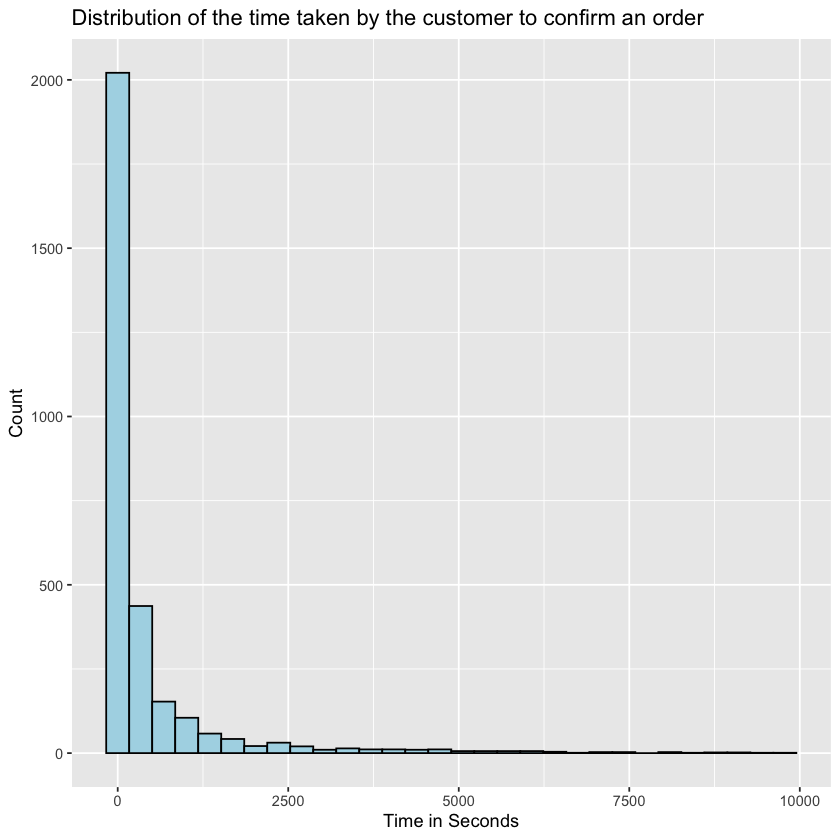

In [18]:
time_1 %>% ggplot() +
  geom_histogram(mapping = aes(x = customer_diff), 
                 fill = "lightblue", col = "black")  +
  labs(x = "Time in Seconds", y = "Count") + ggtitle('Distribution of the time taken by the customer to confirm an order')

In [19]:
arrival_at_pickup_cols <- subsample %>% select(arrival_at_pickup_day_of_month, arrival_at_pickup_weekday_mo_1, arrival_at_pickup_time)
arrival_at_pickup_time <- cbind(time_1, arrival_at_pickup_cols)
arrival_at_pickup_time <- arrival_at_pickup_time %>% mutate(arrive_pickup_t = strptime(arrival_at_pickup_time, format="%I:%M:%S %p"))
arrival_at_pickup_time <- arrival_at_pickup_time %>% mutate(arrival_diff = arrive_pickup_t - confirmation_t)
head(arrival_at_pickup_time)

,order_no,placement_day_of_month,placement_weekday_mo_1,placement_time,confirmation_day_of_month,confirmation_weekday_mo_1,confirmation_time,placement_t,confirmation_t,customer_diff,arrival_at_pickup_day_of_month,arrival_at_pickup_weekday_mo_1,arrival_at_pickup_time,arrive_pickup_t,arrival_diff
,<fct>,<int>,<int>,<fct>,<int>,<int>,<fct>,<dttm>,<dttm>,<drtn>,<int>,<int>,<fct>,<dttm>,<drtn>
12419,Order_No_30,7,2,2:24:11 PM,7,2,2:24:33 PM,2021-06-20 14:24:11,2021-06-20 14:24:33,22 secs,7,2,2:31:29 PM,2021-06-20 14:31:29,416 secs
6255,Order_No_26774,12,4,1:41:59 PM,12,4,1:42:11 PM,2021-06-20 13:41:59,2021-06-20 13:42:11,12 secs,12,4,1:47:26 PM,2021-06-20 13:47:26,315 secs
8030,Order_No_9039,26,2,1:18:16 PM,26,2,1:18:53 PM,2021-06-20 13:18:16,2021-06-20 13:18:53,37 secs,26,2,1:18:56 PM,2021-06-20 13:18:56,3 secs
11001,Order_No_11861,9,4,9:43:20 AM,9,4,9:46:14 AM,2021-06-20 09:43:20,2021-06-20 09:46:14,174 secs,9,4,10:32:45 AM,2021-06-20 10:32:45,2791 secs
909,Order_No_21953,27,2,10:07:56 AM,27,2,10:14:07 AM,2021-06-20 10:07:56,2021-06-20 10:14:07,371 secs,27,2,10:29:06 AM,2021-06-20 10:29:06,899 secs
11700,Order_No_15615,16,2,7:12:16 PM,16,2,7:15:03 PM,2021-06-20 19:12:16,2021-06-20 19:15:03,167 secs,16,2,7:22:55 PM,2021-06-20 19:22:55,472 secs


Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


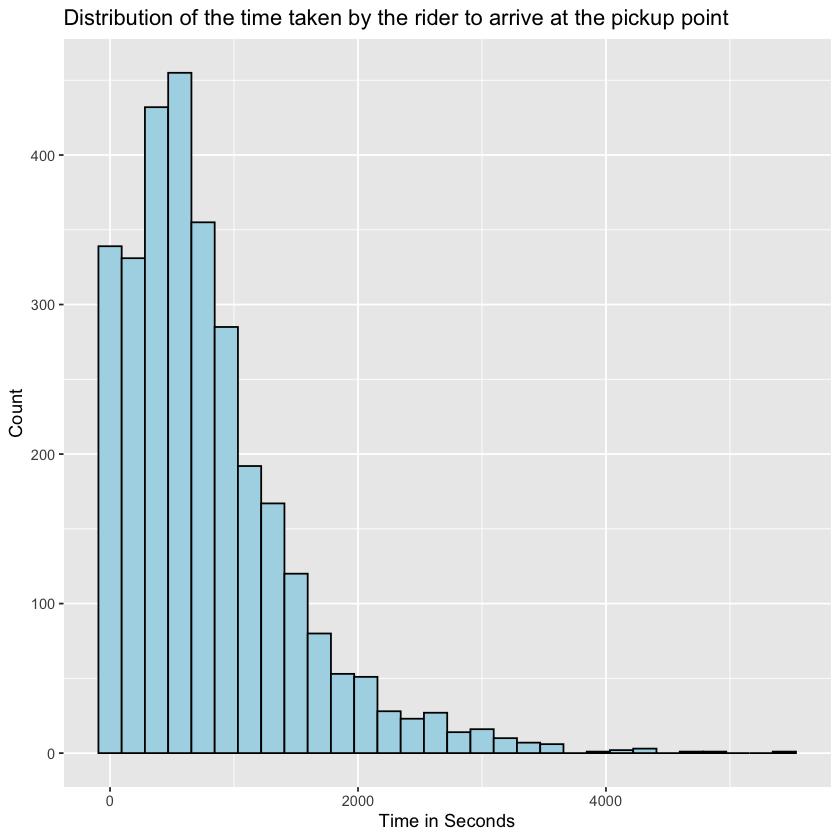

In [20]:
arrival_at_pickup_time %>% ggplot() +
  geom_histogram(mapping = aes(x = arrival_diff), 
                 fill = "lightblue", col = "black") +
  labs(x = "Time in Seconds", y = "Count") + ggtitle('Distribution of the time taken by the rider to arrive at the pickup point')

In [21]:
min(arrival_at_pickup_time$arrival_diff)

Time difference of 2 secs

In [22]:
max(arrival_at_pickup_time$arrival_diff)

Time difference of 5441 secs

In [23]:
### Time rider took at the pickup location
time_at_pickup_cols <- subsample %>% select(pickup_day_of_month, pickup_weekday_mo_1, pickup_time)
at_pickup_time <- cbind(arrival_at_pickup_time, time_at_pickup_cols)
at_pickup_time <- at_pickup_time %>% mutate(pickup_t = strptime(pickup_time, format="%I:%M:%S %p"))
at_pickup_time <- at_pickup_time %>% mutate(pickup_diff = pickup_t - arrive_pickup_t)
head(at_pickup_time)


,order_no,placement_day_of_month,placement_weekday_mo_1,placement_time,confirmation_day_of_month,confirmation_weekday_mo_1,confirmation_time,placement_t,confirmation_t,customer_diff,arrival_at_pickup_day_of_month,arrival_at_pickup_weekday_mo_1,arrival_at_pickup_time,arrive_pickup_t,arrival_diff,pickup_day_of_month,pickup_weekday_mo_1,pickup_time,pickup_t,pickup_diff
,<fct>,<int>,<int>,<fct>,<int>,<int>,<fct>,<dttm>,<dttm>,<drtn>,<int>,<int>,<fct>,<dttm>,<drtn>,<int>,<int>,<fct>,<dttm>,<drtn>
12419,Order_No_30,7,2,2:24:11 PM,7,2,2:24:33 PM,2021-06-20 14:24:11,2021-06-20 14:24:33,22 secs,7,2,2:31:29 PM,2021-06-20 14:31:29,416 secs,7,2,2:37:30 PM,2021-06-20 14:37:30,6.016667 mins
6255,Order_No_26774,12,4,1:41:59 PM,12,4,1:42:11 PM,2021-06-20 13:41:59,2021-06-20 13:42:11,12 secs,12,4,1:47:26 PM,2021-06-20 13:47:26,315 secs,12,4,2:21:40 PM,2021-06-20 14:21:40,34.233333 mins
8030,Order_No_9039,26,2,1:18:16 PM,26,2,1:18:53 PM,2021-06-20 13:18:16,2021-06-20 13:18:53,37 secs,26,2,1:18:56 PM,2021-06-20 13:18:56,3 secs,26,2,1:28:14 PM,2021-06-20 13:28:14,9.300000 mins
11001,Order_No_11861,9,4,9:43:20 AM,9,4,9:46:14 AM,2021-06-20 09:43:20,2021-06-20 09:46:14,174 secs,9,4,10:32:45 AM,2021-06-20 10:32:45,2791 secs,9,4,10:44:42 AM,2021-06-20 10:44:42,11.950000 mins
909,Order_No_21953,27,2,10:07:56 AM,27,2,10:14:07 AM,2021-06-20 10:07:56,2021-06-20 10:14:07,371 secs,27,2,10:29:06 AM,2021-06-20 10:29:06,899 secs,27,2,10:30:08 AM,2021-06-20 10:30:08,1.033333 mins
11700,Order_No_15615,16,2,7:12:16 PM,16,2,7:15:03 PM,2021-06-20 19:12:16,2021-06-20 19:15:03,167 secs,16,2,7:22:55 PM,2021-06-20 19:22:55,472 secs,16,2,7:25:04 PM,2021-06-20 19:25:04,2.150000 mins


In [24]:
min(at_pickup_time$pickup_diff)
max(at_pickup_time$pickup_diff)

Time difference of 1 mins

Time difference of 99.75 mins

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


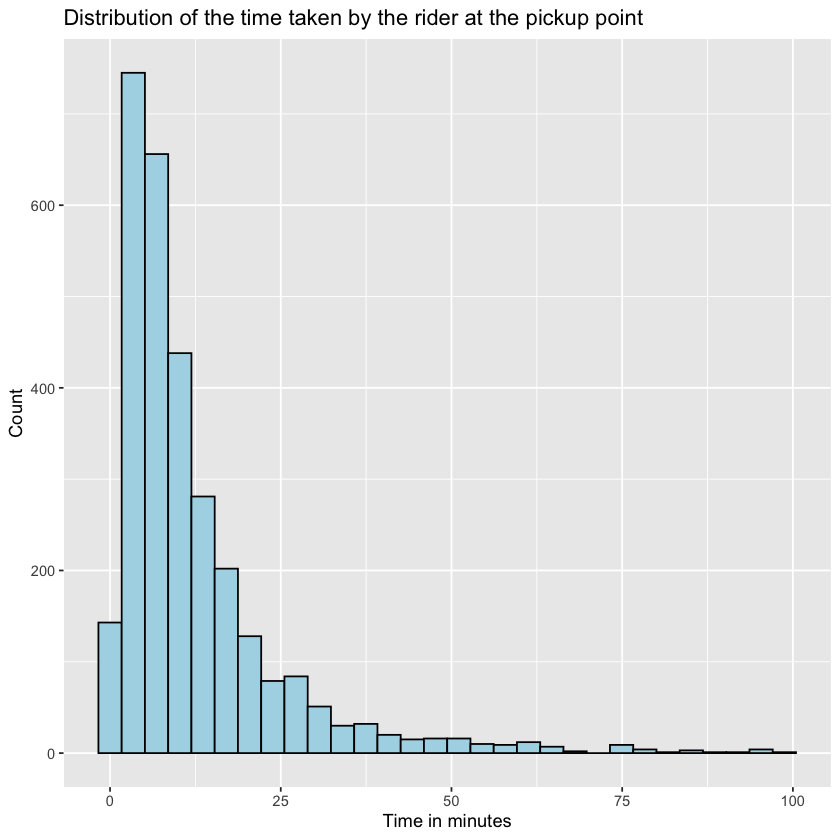

In [25]:
at_pickup_time %>% ggplot() +
  geom_histogram(mapping = aes(x = pickup_diff), 
                 fill = "lightblue", col = "black")  +
  labs(x = "Time in minutes", y = "Count") + ggtitle('Distribution of the time taken by the rider at the pickup point')

In [26]:
### Time took by rider on the road before reaching the destination
time_at_destination_cols <- subsample %>% select(arrival_at_destination_day_of_month, arrival_at_destination_weekday_mo_1, arrival_at_destination_weekday_mo_1, arrival_at_destination_time, time_from_pickup_to_arrival)
arrival_time <- cbind(at_pickup_time, time_at_destination_cols)
arrival_time <- arrival_time %>% mutate(delivery_t = strptime(arrival_at_destination_time, format="%I:%M:%S %p"))
arrival_time <- arrival_time %>% mutate(pickup_hour_of_day=hour(pickup_t),delivery_diff = delivery_t - pickup_t)
total_time <- arrival_time %>% mutate(total_time_taken = minute(seconds_to_period(customer_diff + arrival_diff)) + pickup_diff + delivery_diff)
head(total_time)


,order_no,placement_day_of_month,placement_weekday_mo_1,placement_time,confirmation_day_of_month,confirmation_weekday_mo_1,confirmation_time,placement_t,confirmation_t,customer_diff,⋯,pickup_t,pickup_diff,arrival_at_destination_day_of_month,arrival_at_destination_weekday_mo_1,arrival_at_destination_time,time_from_pickup_to_arrival,delivery_t,pickup_hour_of_day,delivery_diff,total_time_taken
,<fct>,<int>,<int>,<fct>,<int>,<int>,<fct>,<dttm>,<dttm>,<drtn>,⋯,<dttm>,<drtn>,<int>,<int>,<fct>,<int>,<dttm>,<int>,<drtn>,<drtn>
12419,Order_No_30,7,2,2:24:11 PM,7,2,2:24:33 PM,2021-06-20 14:24:11,2021-06-20 14:24:33,22 secs,⋯,2021-06-20 14:37:30,6.016667 mins,7,2,3:41:22 PM,3832,2021-06-20 15:41:22,14,63.86667 mins,76.88333 mins
6255,Order_No_26774,12,4,1:41:59 PM,12,4,1:42:11 PM,2021-06-20 13:41:59,2021-06-20 13:42:11,12 secs,⋯,2021-06-20 14:21:40,34.233333 mins,12,4,2:44:42 PM,1382,2021-06-20 14:44:42,14,23.03333 mins,62.26667 mins
8030,Order_No_9039,26,2,1:18:16 PM,26,2,1:18:53 PM,2021-06-20 13:18:16,2021-06-20 13:18:53,37 secs,⋯,2021-06-20 13:28:14,9.300000 mins,26,2,1:50:29 PM,1335,2021-06-20 13:50:29,13,22.25000 mins,31.55000 mins
11001,Order_No_11861,9,4,9:43:20 AM,9,4,9:46:14 AM,2021-06-20 09:43:20,2021-06-20 09:46:14,174 secs,⋯,2021-06-20 10:44:42,11.950000 mins,9,4,11:24:58 AM,2416,2021-06-20 11:24:58,10,40.26667 mins,101.21667 mins
909,Order_No_21953,27,2,10:07:56 AM,27,2,10:14:07 AM,2021-06-20 10:07:56,2021-06-20 10:14:07,371 secs,⋯,2021-06-20 10:30:08,1.033333 mins,27,2,11:15:02 AM,2694,2021-06-20 11:15:02,10,44.90000 mins,66.93333 mins
11700,Order_No_15615,16,2,7:12:16 PM,16,2,7:15:03 PM,2021-06-20 19:12:16,2021-06-20 19:15:03,167 secs,⋯,2021-06-20 19:25:04,2.150000 mins,16,2,7:43:38 PM,1114,2021-06-20 19:43:38,19,18.56667 mins,30.71667 mins


In [27]:
min(arrival_time$delivery_diff)
max(arrival_time$delivery_diff)
cat("Earliest hour of delivery:",min(arrival_time$pickup_hour_of_day),'\n')
cat("Latest hour of delivery:", max(arrival_time$pickup_hour_of_day))

Time difference of 10 mins

Time difference of 127.4333 mins

Earliest hour of delivery: 7 
Latest hour of delivery: 22

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


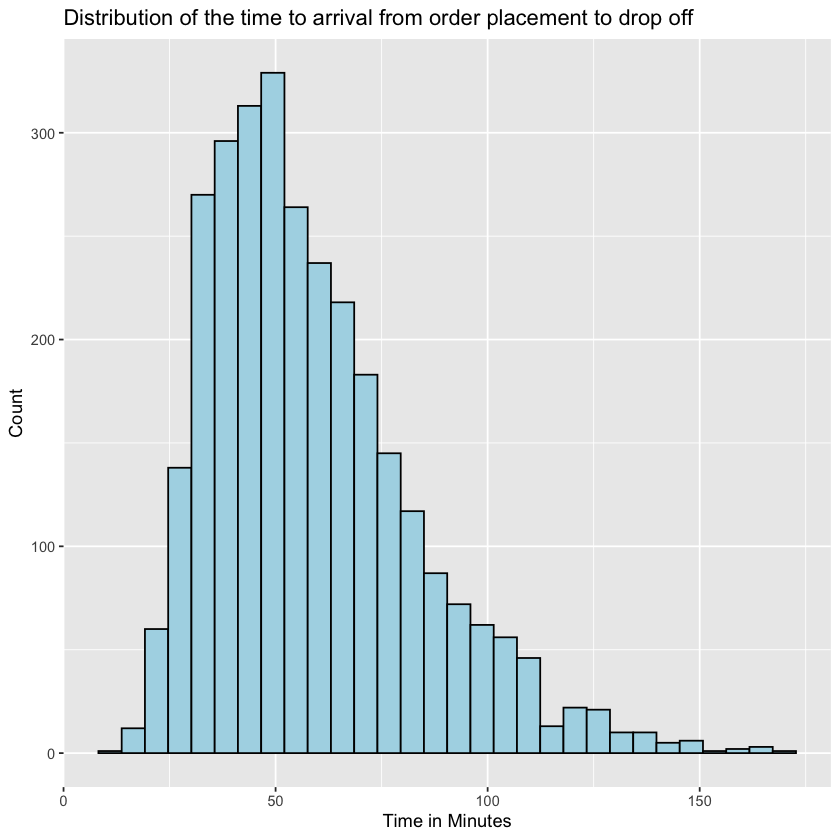

In [28]:
total_time %>% ggplot() +
  geom_histogram(mapping = aes(x = total_time_taken), fill = "lightblue", col = "black")  +
  labs(x = "Time in Minutes", y = "Count") + 
  ggtitle('Distribution of the time to arrival from order placement to drop off')

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


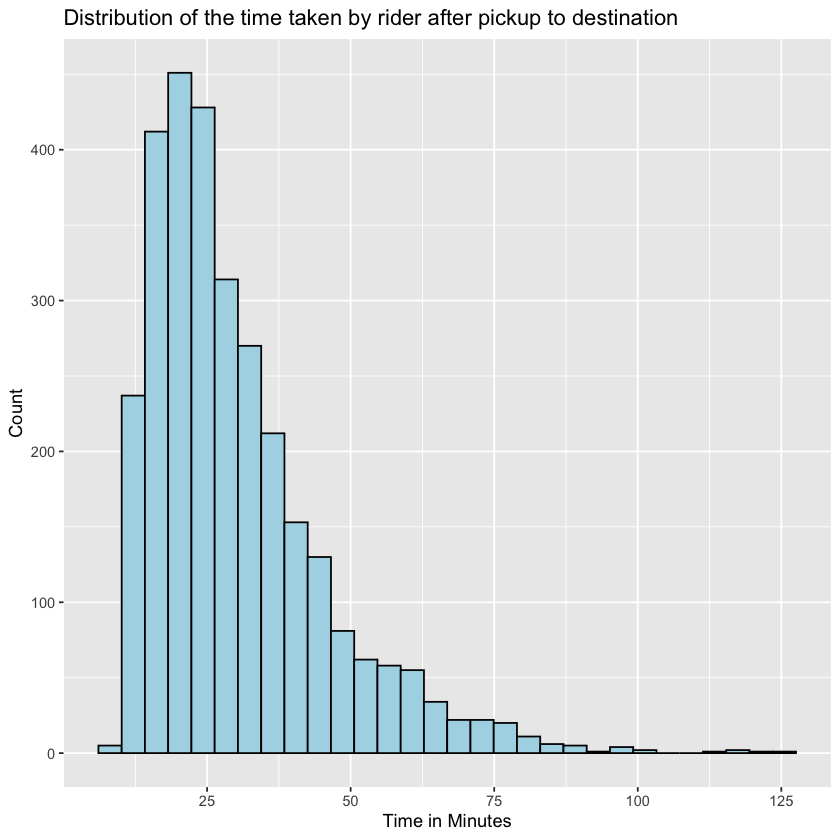

In [29]:
arrival_time %>% ggplot() +
  geom_histogram(mapping = aes(x = delivery_diff), fill = "lightblue", col = "black")  +
  labs(x = "Time in Minutes", y = "Count") + 
  ggtitle('Distribution of the time taken by rider after pickup to destination')

In [30]:
##
# Model Training
##
order_vars <- subsample %>% select(rider_id, distance_km, pickup_lat, pickup_long, destination_lat, destination_long, time_minutes)
pickup_vars <- arrival_time %>% select(pickup_weekday_mo_1, pickup_hour_of_day, time_from_pickup_to_arrival)
model_features_1 <- cbind(order_vars, pickup_vars)
model_features_1$pickup_weekday_mo_1 <- as.factor(model_features_1$pickup_weekday_mo_1)
model_features_1$pickup_hour_of_day <- as.factor(model_features_1$pickup_hour_of_day)
head(model_features_1)

,rider_id,distance_km,pickup_lat,pickup_long,destination_lat,destination_long,time_minutes,pickup_weekday_mo_1,pickup_hour_of_day,time_from_pickup_to_arrival
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>
12419,Rider_Id_238,23,-1.370038,36.91902,-1.257147,36.79506,63.9,2,14,3832
6255,Rider_Id_906,18,-1.279939,36.81924,-1.356237,36.90430,23.0,4,14,1382
8030,Rider_Id_345,15,-1.222762,36.89892,-1.263194,36.79762,22.2,2,13,1335
11001,Rider_Id_770,10,-1.255189,36.78220,-1.314309,36.83927,40.3,4,10,2416
909,Rider_Id_240,20,-1.233973,36.67473,-1.310903,36.76895,44.9,2,10,2694
11700,Rider_Id_461,6,-1.273056,36.81130,-1.283211,36.77777,18.6,2,19,1114


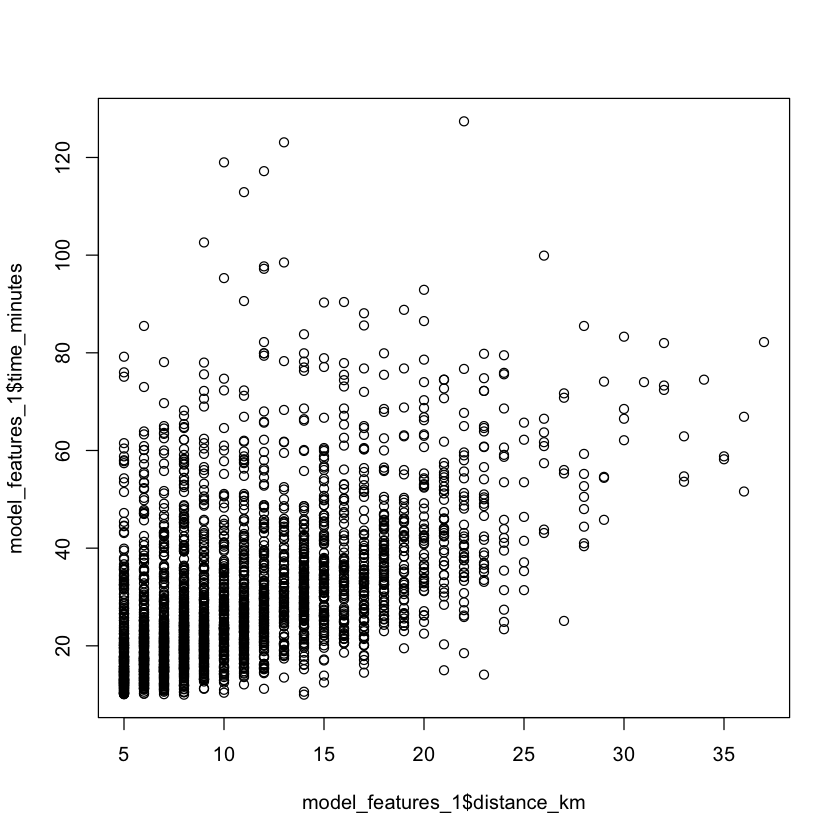

In [31]:
plot(x=model_features_1$distance_km, y=model_features_1$time_minutes)

In [32]:
model_features_rf_1 <- model_features_1 %>% select(-c(rider_id, time_from_pickup_to_arrival))
set.seed(123)
indexes = createDataPartition(model_features_rf_1$time_minutes, p = .8, list = F)
train_set = model_features_rf_1[indexes, ]
test_set = model_features_rf_1[-indexes, ]
#train_svr <- train_svr %>% select(distance_km, time_from_pickup_to_arrival)
#test_svr <- test_svr %>% select(distance_km, time_from_pickup_to_arrival)
head(train_set)

,distance_km,pickup_lat,pickup_long,destination_lat,destination_long,time_minutes,pickup_weekday_mo_1,pickup_hour_of_day
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
12419,23,-1.370038,36.91902,-1.257147,36.79506,63.9,2,14
6255,18,-1.279939,36.81924,-1.356237,36.90430,23.0,4,14
8030,15,-1.222762,36.89892,-1.263194,36.79762,22.2,2,13
11001,10,-1.255189,36.78220,-1.314309,36.83927,40.3,4,10
909,20,-1.233973,36.67473,-1.310903,36.76895,44.9,2,10
3247,5,-1.297090,36.77718,-1.274644,36.80368,57.8,3,11


In [33]:
## Computing correlation matrix
corr_matrix <- model_features_rf_1 %>% select_if(is.numeric) %>% cor()
# corrplot(corr_matrix)
head(round(corr_matrix, 2))

,distance_km,pickup_lat,pickup_long,destination_lat,destination_long,time_minutes
distance_km,1.00,-0.09,0.15,-0.07,0.15,0.51
pickup_lat,-0.09,1.00,-0.14,0.04,0.09,-0.04
pickup_long,0.15,-0.14,1.00,0.04,0.04,0.03
destination_lat,-0.07,0.04,0.04,1.00,0.06,-0.04
destination_long,0.15,0.09,0.04,0.06,1.00,0.09
time_minutes,0.51,-0.04,0.03,-0.04,0.09,1.00


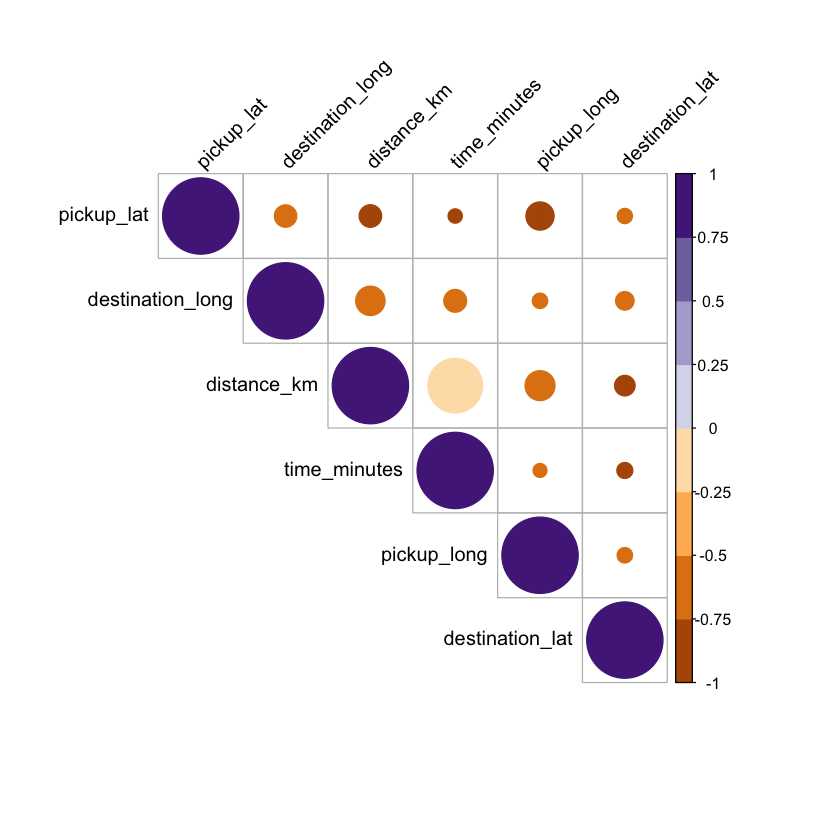

In [34]:
library(RColorBrewer)
corrplot(corr_matrix, type="upper", order="hclust", col=brewer.pal(n=8, name="PuOr"), tl.col="black", tl.srt=45)

In [35]:
# Create random forest for regression
set.seed(24)
ozone.rf <- randomForest(time_minutes ~ ., data = train_set, mtry = 5,
                         importance = TRUE, na.action = na.omit)

In [36]:
ozone.rf


Call:
 randomForest(formula = time_minutes ~ ., data = train_set, mtry = 5,      importance = TRUE, na.action = na.omit) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 5

          Mean of squared residuals: 170.2676
                    % Var explained: 28.01

In [37]:
y_pred = predict(ozone.rf, test_set)
head(y_pred)

11700    15267     4677     7152    14612    14808 
22.57198 41.50889 40.81072 36.60279 27.82713 26.79473

In [38]:
rmse(test_svr$time_minutes,y_pred)
sqrt(190.2795)

ERROR: Error in se(actual, predicted): object 'test_svr' not found


In [74]:
# Define the control
trControl <- trainControl(method = "cv",
    number = 5,
    search = "grid")

In [75]:
# try the random forest model with default values
#run the model
rf_default <- train(time_minutes ~ ., data = train_set, 
                    method="rf", metric="RMSE", importance=T,
                    trControl = trControl)
# print the results
print(rf_default)

Random Forest 

2402 samples
   7 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1922, 1921, 1922, 1921, 1922 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE      
   2    14.07571  0.2334791  10.207892
  14    13.69180  0.2485022   9.755346
  26    13.83699  0.2376203   9.851723

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 14.


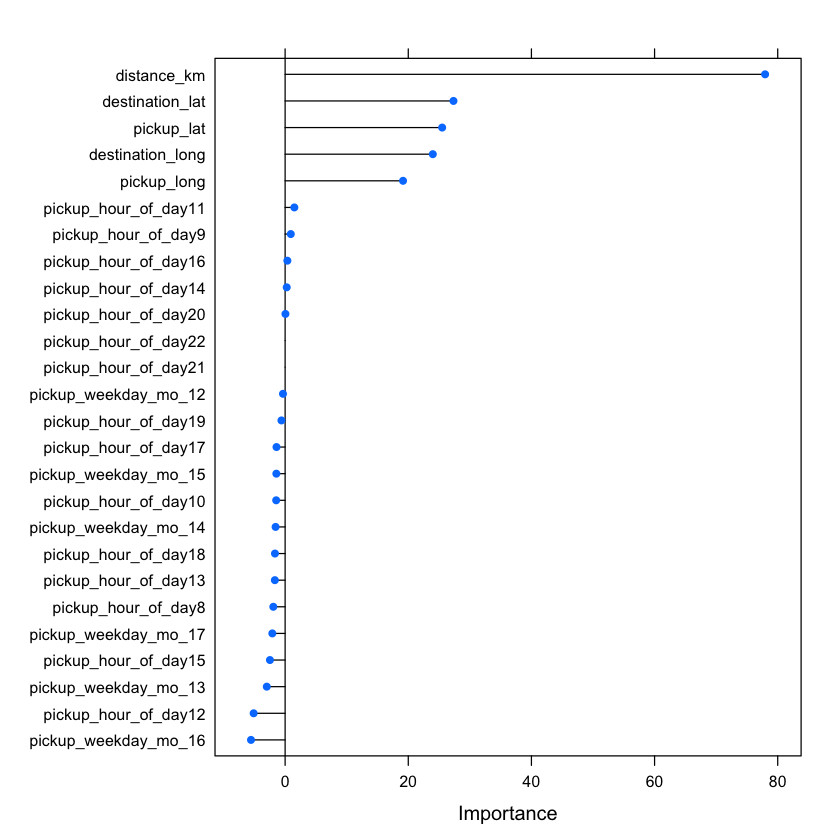

In [77]:
importance <- varImp(rf_default, scale=F)
plot(importance)

In [91]:
head(model_features_1)

,rider_id,distance_km,pickup_lat,pickup_long,destination_lat,destination_long,time_minutes,pickup_weekday_mo_1,pickup_hour_of_day,time_from_pickup_to_arrival
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>
1,Rider_Id_856,16,-1.351453,36.89932,-1.295004,36.81436,33.2,5,11,1993
2,Rider_Id_855,9,-1.281301,36.83240,-1.257147,36.79506,22.4,5,9,1341
3,Rider_Id_770,9,-1.266597,36.79212,-1.295041,36.80982,20.2,1,10,1214
4,Rider_Id_124,9,-1.302583,36.76708,-1.257309,36.80601,53.2,5,15,3191
5,Rider_Id_114,5,-1.279395,36.82536,-1.276574,36.85136,23.0,5,9,1380
6,Rider_Id_394,9,-1.255189,36.78220,-1.300255,36.82566,56.6,2,12,3398


In [78]:
min(model_features_1$distance_km)
max(model_features_1$distance_km)

[1] 5

[1] 36

In [3]:
########## Add rider details to our model
rider_data <- 'Sendy/Riders.csv'
rider_details <- read.csv(rider_data, header=T, stringsAsFactors = F) %>% clean_names()
#combined_data <- left_join(model_features_1, rider_details, by="rider_id")
head(rider_details)

,rider_id,no_of_orders,age,average_rating,no_of_ratings
,<chr>,<int>,<int>,<dbl>,<int>
1,Rider_Id_396,2946,2298,14.0,1159
2,Rider_Id_479,360,951,13.5,176
3,Rider_Id_648,1746,821,14.3,466
4,Rider_Id_753,314,980,12.5,75
5,Rider_Id_335,536,1113,13.7,156
6,Rider_Id_720,2608,1798,13.2,504


In [5]:
colSums(sapply(rider_details, is.na))

rider_id   no_of_orders            age average_rating  no_of_ratings 
             0              0              0              0              0

In [40]:
rider_details <- rider_details %>% mutate(rating=round(average_rating)) 
rider_details$rating <- as.factor(rider_details$rating)
rider_details$rider_id <- as.factor(rider_details$rider_id)
head(rider_details)

,rider_id,no_of_orders,age,average_rating,no_of_ratings,rating
,<fct>,<int>,<int>,<dbl>,<int>,<fct>
1,Rider_Id_396,2946,2298,14.0,1159,14
2,Rider_Id_479,360,951,13.5,176,14
3,Rider_Id_648,1746,821,14.3,466,14
4,Rider_Id_753,314,980,12.5,75,12
5,Rider_Id_335,536,1113,13.7,156,14
6,Rider_Id_720,2608,1798,13.2,504,13


In [41]:
rider_details <- rider_details %>% select(-c(average_rating,no_of_ratings))
head(rider_details)

,rider_id,no_of_orders,age,rating
,<fct>,<int>,<int>,<fct>
1,Rider_Id_396,2946,2298,14
2,Rider_Id_479,360,951,14
3,Rider_Id_648,1746,821,14
4,Rider_Id_753,314,980,12
5,Rider_Id_335,536,1113,14
6,Rider_Id_720,2608,1798,13


In [42]:
model_features_2 <- left_join(model_features_1, rider_details, by="rider_id")
model_features_2 <- model_features_2 %>% select(-c(rider_id,time_from_pickup_to_arrival))
head(model_features_2)

,distance_km,pickup_lat,pickup_long,destination_lat,destination_long,time_minutes,pickup_weekday_mo_1,pickup_hour_of_day,no_of_orders,age,rating
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,23,-1.370038,36.91902,-1.257147,36.79506,63.9,2,14,7921,2591,14
2,18,-1.279939,36.81924,-1.356237,36.90430,23.0,4,14,3571,1236,14
3,15,-1.222762,36.89892,-1.263194,36.79762,22.2,2,13,3036,1426,14
4,10,-1.255189,36.78220,-1.314309,36.83927,40.3,4,10,2311,872,14
5,20,-1.233973,36.67473,-1.310903,36.76895,44.9,2,10,1541,1243,14
6,6,-1.273056,36.81130,-1.283211,36.77777,18.6,2,19,60,339,15


In [43]:
## Computing correlation matrix
corr_matrix <- model_features_2 %>% select_if(is.numeric) %>% cor()
# corrplot(corr_matrix)
head(round(corr_matrix, 2))

,distance_km,pickup_lat,pickup_long,destination_lat,destination_long,time_minutes,no_of_orders,age
distance_km,1.00,-0.09,0.15,-0.07,0.15,0.51,0.08,0.10
pickup_lat,-0.09,1.00,-0.14,0.04,0.09,-0.04,0.00,0.01
pickup_long,0.15,-0.14,1.00,0.04,0.04,0.03,-0.02,-0.02
destination_lat,-0.07,0.04,0.04,1.00,0.06,-0.04,0.00,-0.01
destination_long,0.15,0.09,0.04,0.06,1.00,0.09,-0.01,0.01
time_minutes,0.51,-0.04,0.03,-0.04,0.09,1.00,0.02,0.05


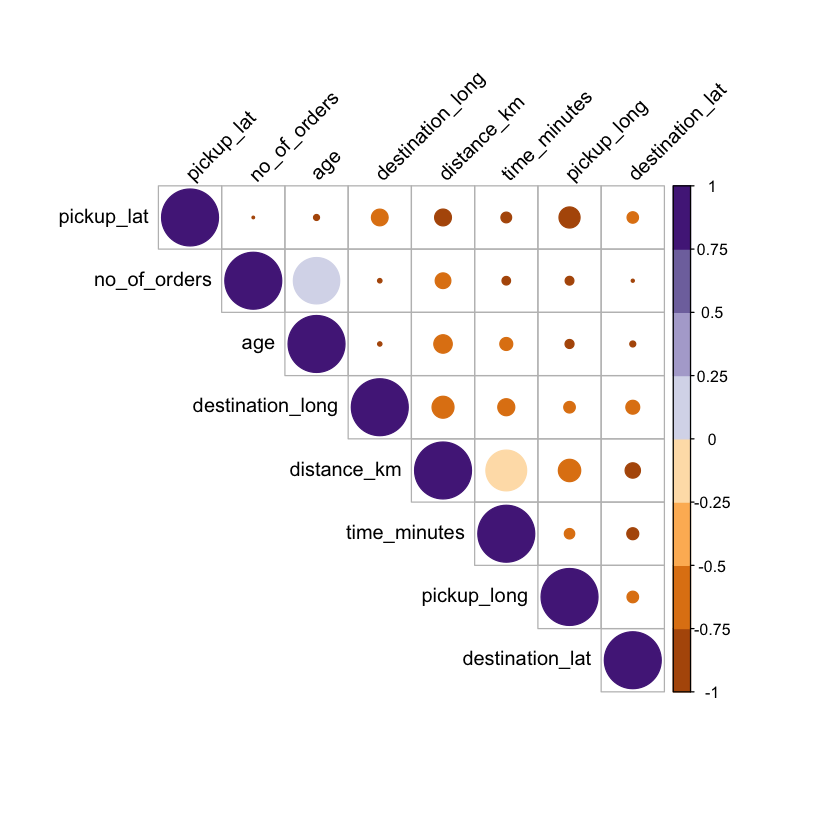

In [44]:
library(RColorBrewer)
corrplot(corr_matrix, type="upper", order="hclust", col=brewer.pal(n=8, name="PuOr"), tl.col="black", tl.srt=45)

In [45]:

cor.mtest <- function(mat, ...){
    mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- matrix(NA, n, n)
    diag(p.mat) <- 0
    for (i in 1:(n-1)){
       for (j in (i+1):n){
           tmp <- cor.test(mat[,i], mat[,j], ...)
           p.mat[i,j] <- p.mat[j,i] <- tmp$p.value
       }
    }
    colnames(p.mat) <- rownames(p.mat) <- colnames(mat)
    p.mat
}


In [46]:
# matrix of the p-value of the correlation
data_ <- model_features_2 %>% select_if(is.numeric)
p.mat <- cor.mtest(data_)
head(p.mat)

,distance_km,pickup_lat,pickup_long,destination_lat,destination_long,time_minutes,no_of_orders,age
distance_km,0.000000e+00,1.637331e-06,2.086667e-17,6.613535e-05,3.256259e-16,1.736404e-200,3.195726e-05,8.445316e-09
pickup_lat,1.637331e-06,0.000000e+00,5.489548e-14,2.713690e-02,2.370896e-06,5.238053e-02,9.051402e-01,5.470855e-01
pickup_long,2.086667e-17,5.489548e-14,0.000000e+00,2.359037e-02,2.416921e-02,6.669682e-02,1.945353e-01,1.720208e-01
destination_lat,6.613535e-05,2.713690e-02,2.359037e-02,0.000000e+00,1.162571e-03,1.533916e-02,8.665791e-01,5.488231e-01
destination_long,3.256259e-16,2.370896e-06,2.416921e-02,1.162571e-03,0.000000e+00,9.342275e-07,7.372076e-01,7.509636e-01
time_minutes,1.736404e-200,5.238053e-02,6.669682e-02,1.533916e-02,9.342275e-07,0.000000e+00,2.165094e-01,4.645628e-03


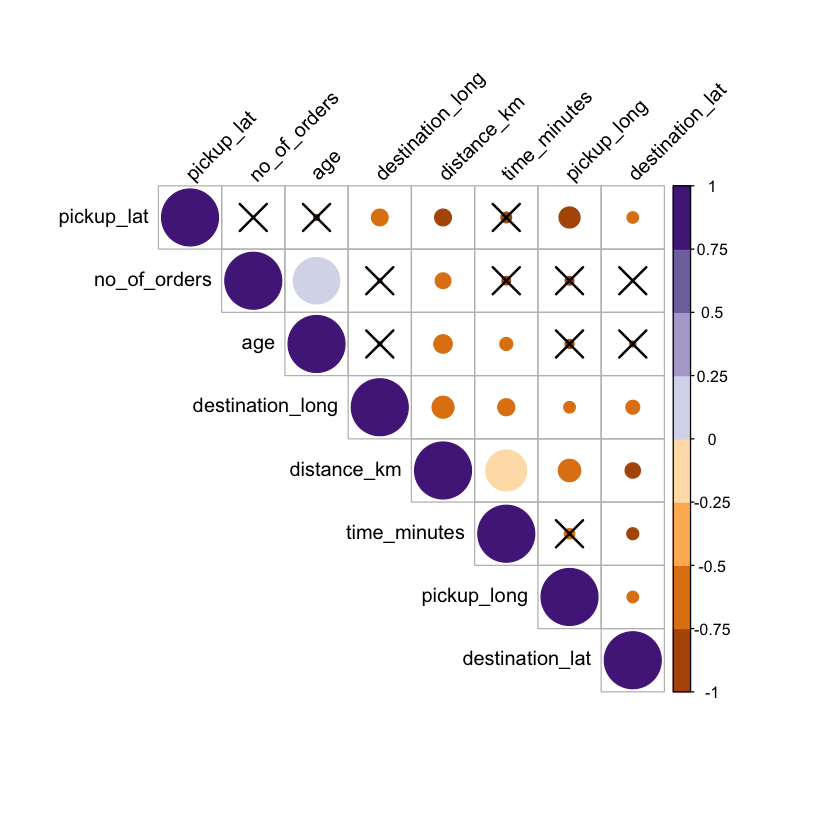

In [47]:
corrplot(corr_matrix, type="upper", order="hclust", p.mat = p.mat, sig.level = 0.05, col=brewer.pal(n=8, name="PuOr"), tl.col="black", tl.srt=45)

In [111]:
rf_default <- train(time_minutes ~ ., data = model_features_2, 
                    method="rf", metric="RMSE", importance=T,
                    trControl = trControl)
# print the results
print(rf_default)

Random Forest 

3000 samples
  10 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2399, 2401, 2400, 2400, 2400 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE      
   2    14.56356  0.2182216  10.645476
  20    13.75998  0.2461160   9.793461
  38    13.90231  0.2338857   9.901433

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 20.


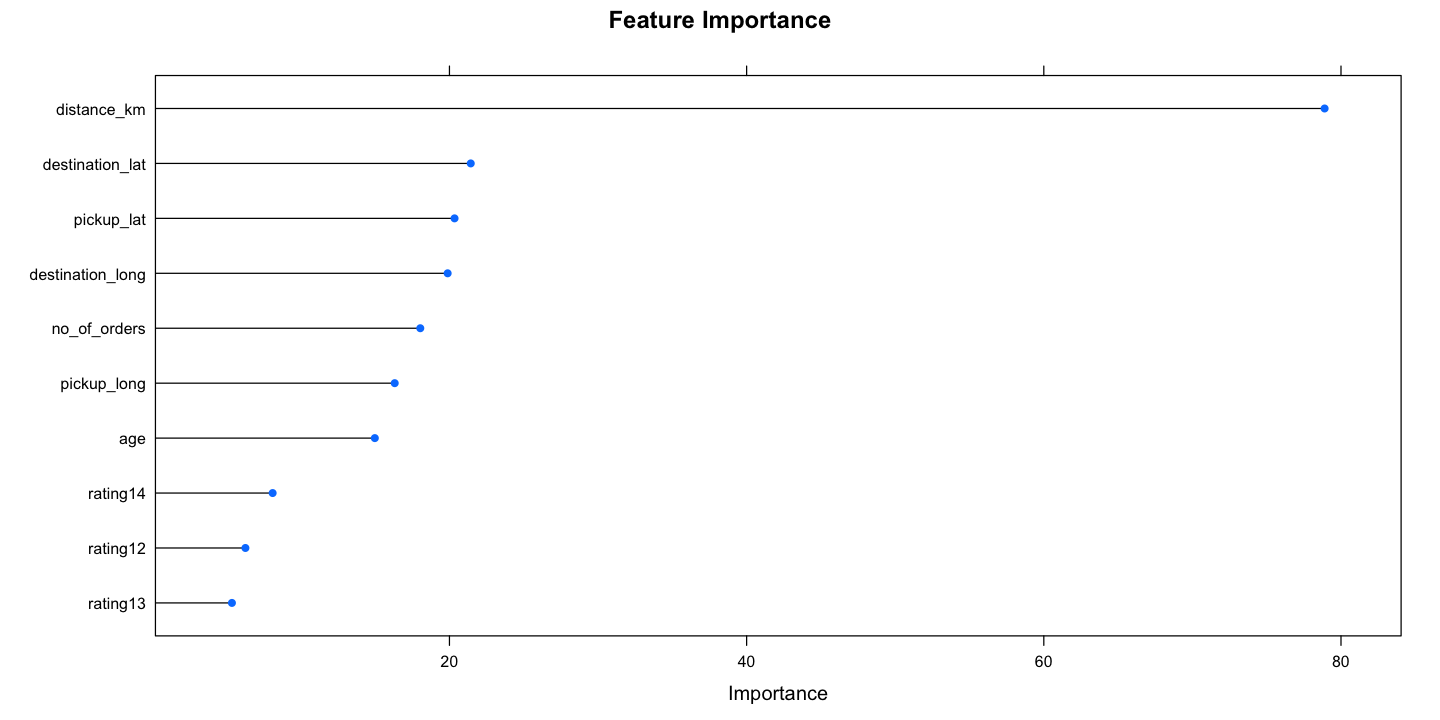

In [113]:
importance <- varImp(rf_default, scale=F)
options(warn=-1, repr.plot.width = 12, repr.plot.height = 6)
plot(importance,10, main="Feature Importance")

In [48]:

set.seed(123)
indexes = createDataPartition(model_features_2$time_minutes, p = .8, list = F)
train_rf = model_features_2[indexes, ]
test_rf = model_features_2[-indexes, ]
head(train_rf)

,distance_km,pickup_lat,pickup_long,destination_lat,destination_long,time_minutes,pickup_weekday_mo_1,pickup_hour_of_day,no_of_orders,age,rating
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,23,-1.370038,36.91902,-1.257147,36.79506,63.9,2,14,7921,2591,14
2,18,-1.279939,36.81924,-1.356237,36.90430,23.0,4,14,3571,1236,14
3,15,-1.222762,36.89892,-1.263194,36.79762,22.2,2,13,3036,1426,14
4,10,-1.255189,36.78220,-1.314309,36.83927,40.3,4,10,2311,872,14
5,20,-1.233973,36.67473,-1.310903,36.76895,44.9,2,10,1541,1243,14
7,5,-1.297090,36.77718,-1.274644,36.80368,57.8,3,11,342,875,14


In [49]:
sub_train_rf = train_rf %>% select(distance_km, pickup_long, pickup_lat, destination_lat, destination_long, pickup_weekday_mo_1, pickup_hour_of_day, no_of_orders, rating, time_minutes)
head(sub_train_rf)

,distance_km,pickup_long,pickup_lat,destination_lat,destination_long,pickup_weekday_mo_1,pickup_hour_of_day,no_of_orders,rating,time_minutes
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<fct>,<dbl>
1,23,36.91902,-1.370038,-1.257147,36.79506,2,14,7921,14,63.9
2,18,36.81924,-1.279939,-1.356237,36.90430,4,14,3571,14,23.0
3,15,36.89892,-1.222762,-1.263194,36.79762,2,13,3036,14,22.2
4,10,36.78220,-1.255189,-1.314309,36.83927,4,10,2311,14,40.3
5,20,36.67473,-1.233973,-1.310903,36.76895,2,10,1541,14,44.9
7,5,36.77718,-1.297090,-1.274644,36.80368,3,11,342,14,57.8


In [50]:
### Hyperparameter tuning
seed <- 23

control <- trainControl(method="repeatedcv", number=10, repeats=3, search="grid")
set.seed(seed)
tunegrid <- expand.grid(.mtry=c(8:18))
rf_tuning <- train(time_minutes ~ ., data = sub_train_rf, 
                    method="rf", metric="RMSE", tuneGrid=tunegrid, importance=T,
                    trControl = control)
# print the results
print(rf_tuning)

Random Forest 

2403 samples
   9 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 2163, 2162, 2163, 2162, 2162, 2162, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   8    12.84423  0.3048709  9.263962
   9    12.82492  0.3068657  9.246688
  10    12.82055  0.3072888  9.248520
  11    12.81529  0.3079127  9.245908
  12    12.82284  0.3071189  9.257701
  13    12.81441  0.3081413  9.247795
  14    12.82269  0.3073545  9.254487
  15    12.81010  0.3088787  9.243413
  16    12.82700  0.3071809  9.263463
  17    12.83981  0.3058495  9.268208
  18    12.83530  0.3064277  9.268576

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 15.


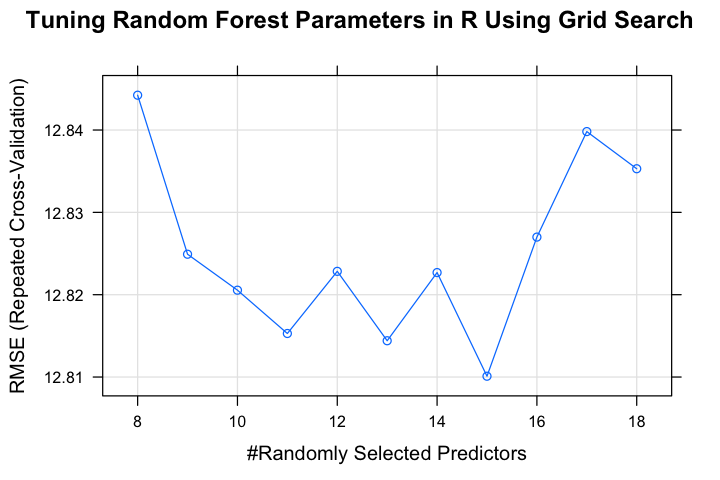

In [51]:
options(warn=-1, repr.plot.width = 6, repr.plot.height = 4)
plot(rf_tuning, main="Tuning Random Forest Parameters in R Using Grid Search")

rf variable importance

  only 20 most important variables shown (out of 37)

                     Overall
distance_km          69.7262
destination_lat      27.1316
pickup_long          23.0620
pickup_lat           21.3987
destination_long     15.8302
rating14              8.5346
rating12              8.3319
rating13              6.6468
rating10              5.2719
no_of_orders          4.9281
pickup_hour_of_day16  4.6941
pickup_hour_of_day21  4.2658
pickup_weekday_mo_13  3.1708
pickup_weekday_mo_16  2.7087
pickup_hour_of_day17  1.1409
pickup_hour_of_day8   0.8553
pickup_hour_of_day18  0.7791
pickup_hour_of_day13  0.7037
pickup_hour_of_day19  0.4432
pickup_weekday_mo_12  0.0728


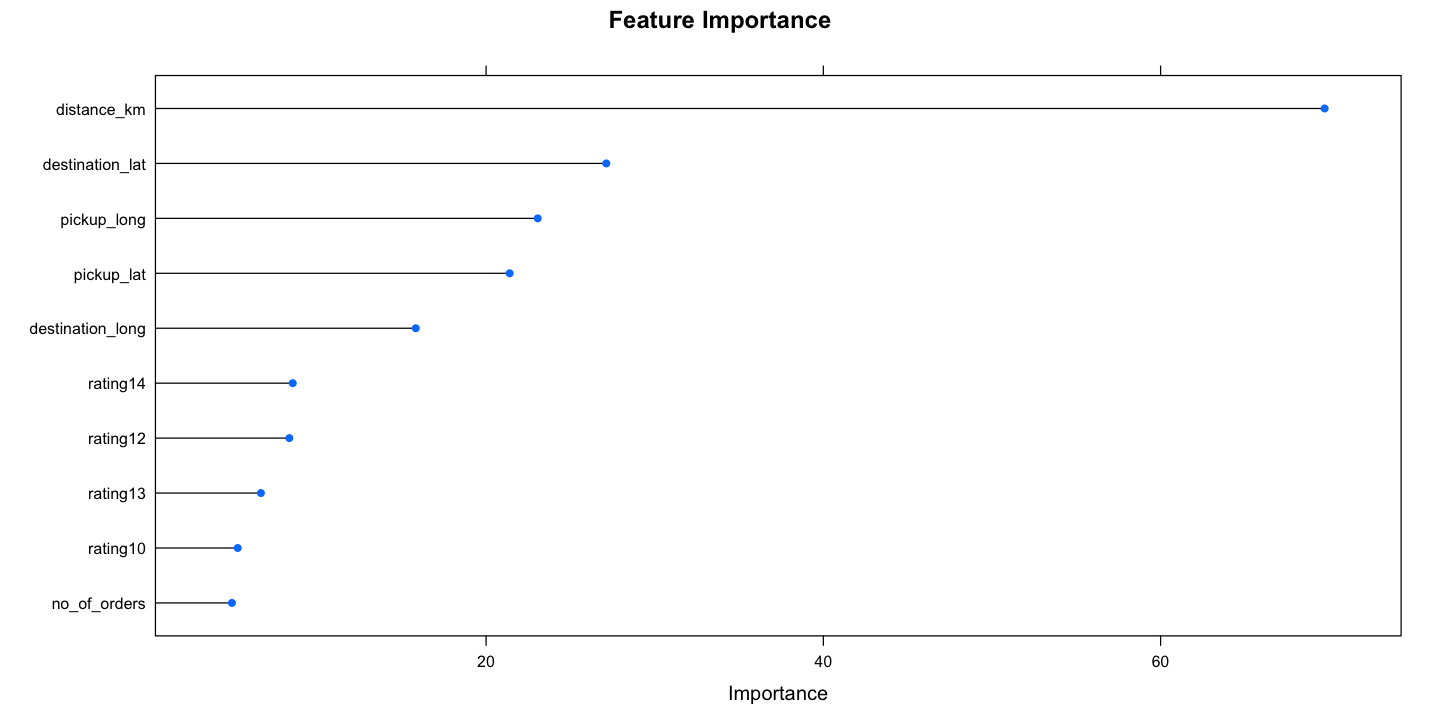

In [52]:
importance <- varImp(rf_tuning, scale=F)
options(warn=-1, repr.plot.width = 12, repr.plot.height = 6)
plot(importance,10, main="Feature Importance")
print(importance)

In [47]:
pred = predict(rf_tuning, test_rf)
head(pred)

2        4       17       22       23       32 
1342.785 1614.198 1207.251 1617.017 2422.131 2121.814

[1] "2"   "4"   "17"  "22"  "23"  "32"  "33"  "37"  "46"  "55"  "58"  "68" 
 [13] "73"  "74"  "85"  "86"  "92"  "100" "102" "105" "111" "114" "117" "121"
 [25] "128" "129" "131" "132" "140" "141" "148" "155" "157" "162" "173" "175"
 [37] "182" "185" "187" "189" "195" "198" "202" "203" "205" "206" "209" "217"
 [49] "219" "220" "223" "237" "241" "242" "244" "249" "252" "260" "264" "271"
 [61] "282" "290" "302" "303" "306" "315" "321" "324" "327" "331" "339" "341"
 [73] "344" "356" "367" "369" "374" "380" "382" "384" "387" "395" "400" "409"
 [85] "419" "429" "431" "441" "449" "450" "458" "459" "462" "470" "473" "484"
 [97] "491" "496" "501" "502" "516" "526" "531" "532" "535" "537" "540" "545"
[109] "557" "558" "572" "574" "576" "577" "578" "581" "583" "585" "595" "609"
[121] "611" "612" "616" "621" "623" "633" "636" "639" "640" "641" "643" "645"
[133] "646" "655" "659" "679" "682" "683" "686" "687" "695" "700" "704" "716"
[145] "726" "727" "729" "734" "738" "740" "742" "745" "749" "752" "753" "755"
[157] "756" "758" "759" "762" "766" "767" "775" "788" "789" "804" "813" "818"
[169] "819" "822" "824" "835" "842" "844" "853" "860" "892" "893" "903" "906"
[181] "909" "914" "919" "922" "927" "930" "936" "940" "948" "952" "953" "956"
[193] "957" "964" "973" "979" "981" "984" "996"

### One-Hot encoding of categorical Variables

In [20]:
factor_cols <- model_features_2 %>% select_if(is.factor)
factor_inputs <- model_features_2 %>% select(time_from_pickup_to_arrival) %>% cbind(factor_cols)
dummies_model <- dummyVars(time_from_pickup_to_arrival ~ ., data=factor_inputs)
# Create the dummy variables using predict. The Y variable (Time_from_pickup_to_arrival) will not be present in trainData_mat.
dummy_vars_matrix <- predict(dummies_model, newdata = factor_inputs)
# Convert to dataframe
dummy_vars.df <- data.frame(dummy_vars_matrix)
head(dummy_vars.df)

,pickup_weekday_mo_1.1,pickup_weekday_mo_1.2,pickup_weekday_mo_1.3,pickup_weekday_mo_1.4,pickup_weekday_mo_1.5,pickup_weekday_mo_1.6,pickup_weekday_mo_1.7,pickup_hour_of_day.7,pickup_hour_of_day.8,pickup_hour_of_day.9,⋯,rating.3,rating.6,rating.8,rating.9,rating.10,rating.11,rating.12,rating.13,rating.14,rating.15
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,1,0
6,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1


In [21]:
numeric_cols <- model_features_2 %>% select_if(is.numeric) %>% select(-time_from_pickup_to_arrival)
new_data <- cbind(numeric_cols,dummy_vars.df)
preProcess_range_model <- preProcess(new_data, method="range")
trainData <- predict(preProcess_range_model, newdata = new_data)
head(trainData)

Warning message in preProcess.default(new_data, method = "range"):
“No variation for for: rating.0, rating.3, rating.6, rating.8, rating.9”

,distance_km,pickup_lat,pickup_long,destination_lat,destination_long,no_of_orders,age,no_of_ratings,pickup_weekday_mo_1.1,pickup_weekday_mo_1.2,⋯,rating.3,rating.6,rating.8,rating.9,rating.10,rating.11,rating.12,rating.13,rating.14,rating.15
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3793103,0.1689089,0.7738025,0.3371349,0.4687445,0.03891570,0.06241445,0.029181185,0,0,⋯,0,0,0,0,0,0,0,0,1,0
2,0.1379310,0.4543103,0.5504428,0.4608457,0.4149827,0.08922887,0.04708459,0.048344948,0,0,⋯,0,0,0,0,0,0,0,0,1,0
3,0.1379310,0.5141304,0.4160036,0.3370150,0.4560916,0.23554780,0.20832193,0.231271777,1,0,⋯,0,0,0,0,0,0,0,0,1,0
4,0.1379310,0.3677303,0.3324345,0.4603170,0.4454791,0.33586611,0.29920613,0.459059233,0,0,⋯,0,0,0,0,0,0,0,0,1,0
5,0.0000000,0.4620654,0.5269709,0.3973631,0.5718553,0.02782627,0.12181768,0.010888502,0,0,⋯,0,0,0,0,0,0,0,0,1,0
6,0.1379310,0.5605416,0.3829106,0.3199745,0.5002250,0.01488859,0.03449220,0.005226481,0,1,⋯,0,0,0,0,0,0,0,0,0,1


In [246]:
apply(trainData[, 1:ncol(trainData)], 2, FUN=function(x){c('min'=min(x),'max'=max(x))})

,distance_km,pickup_lat,pickup_long,destination_lat,destination_long,no_of_orders,age,no_of_ratings,pickup_weekday_mo_1.1,pickup_weekday_mo_1.2,⋯,rating.3,rating.6,rating.8,rating.9,rating.10,rating.11,rating.12,rating.13,rating.14,rating.15
min,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
max,1,1,1,1,1,1,1,1,1,1,⋯,0,0,0,0,1,1,1,1,1,1


In [22]:
trainData$time_from_pickup_to_arrival <- model_features_2$time_from_pickup_to_arrival
dim(trainData)

[1] 1000   42

In [248]:
rf_scaled <- train(time_from_pickup_to_arrival ~ ., data = trainData, 
                    method="rf", metric="RMSE", importance=T,
                    trControl = trControl)
# print the results
print(rf_scaled)

Random Forest 

1000 samples
  41 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 800, 800, 800, 800, 800 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    870.4044  0.2102210  644.6855
  21    828.1750  0.2356110  599.5494
  41    833.1458  0.2300118  600.9304

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 21.


In [45]:
importance <- varImp(rf_scaled)
options(warn=-1, repr.plot.width = 12, repr.plot.height = 6)
plot(importance,10, main="Feature Importance")

ERROR: Error in varImp(rf_scaled): object 'rf_scaled' not found
